In [34]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Statistical tests and time series analysis
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)



In [35]:
# Load the NIFTY-50 dataset
df = pd.read_csv('nifty50.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (249, 7)

Column Names:
['Date', 'Open', 'High', 'Low', 'Close', 'Shares Traded', 'Turnover (? Cr)']

First 5 rows:
        Date      Open      High      Low     Close  Shares Traded  \
0  27-Jun-24  23881.55  24087.45  23805.4  24044.50      515227010   
1  28-Jun-24  24085.90  24174.00  23985.8  24010.60      354779832   
2  01-Jul-24  23992.95  24164.00  23992.7  24141.95      242468081   
3  02-Jul-24  24228.75  24236.35  24056.4  24123.85      309629240   
4  03-Jul-24  24291.75  24309.15  24207.1  24286.50      289201551   

   Turnover (? Cr)  
0         61216.71  
1         41242.87  
2         28204.06  
3         34838.65  
4         36661.17  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             249 non-null    object 
 1   Open             245 non-null    float64
 2   High          

# Data Exploration

## 1.1 Missing Values Analysis and Imputation Techniques

In [36]:
print("Missing Values Analysis:")
print("=" * 50)
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing Count': missing_values.values,
    'Missing Percentage': missing_percentage.values
})

print(missing_df[missing_df['Missing Count'] > 0])


print(f"\nTotal missing values: {df.isnull().sum().sum()}")
print(f"Percentage of complete cases: {(df.dropna().shape[0]/df.shape[0])*100:.2f}%")

Missing Values Analysis:
            Column  Missing Count  Missing Percentage
1             Open              4            1.606426
2             High              2            0.803213
3              Low              1            0.401606
4            Close              2            0.803213
6  Turnover (? Cr)              2            0.803213

Total missing values: 11
Percentage of complete cases: 95.58%


### Imputation Techniques for NIFTY-50 Time Series Data

**1. Forward Fill**: Uses the last valid observation to fill missing values
- **Suitable for**: Stock prices where values change gradually
- **Assumption**: Recent price is the best estimate for missing value

**2. Backward Fill**: Uses the next valid observation to fill missing values
- **Suitable for**: When future information is available and relevant

**3. Linear Interpolation**: Estimates missing values using linear relationship between known points
- **Suitable for**: Time series with smooth trends
- **Best for**: Stock price data with consistent trends

**4. Moving Average**: Uses average of surrounding values
- **Suitable for**: Smoothing out short-term fluctuations
- **Parameters**: Window size determines smoothing level

**5. Seasonal Interpolation**: Considers seasonal patterns in the data
- **Suitable for**: Data with clear seasonal patterns
- **Best for**: Long-term stock data with recurring patterns

In [37]:
# Create a copy for demonstration
df_demo = df.copy()

#selected Linear Interpolation
df_interpolate = df_demo.interpolate(method='linear')
    

df_clean = df_interpolate.copy()
print(f"Selected method: Linear Interpolation")
print(f"Remaining missing values: {df_clean.isnull().sum().sum()}")


Selected method: Linear Interpolation
Remaining missing values: 0


## 1.2 Data Preprocessing and Visualization

In [38]:
# Assuming the dataset has a date column, convert it to datetime
date_columns = [col for col in df_clean.columns if 'date' in col.lower() or 'time' in col.lower()]
if date_columns:
    df_clean[date_columns[0]] = pd.to_datetime(df_clean[date_columns[0]])
    df_clean.set_index(date_columns[0], inplace=True)
    print(f"Date column '{date_columns[0]}' converted to datetime and set as index")


# Display data types and sample data
print("\nData Types:")
print(df_clean.dtypes)
print("\nSample Data:")
print(df_clean.head())

Date column 'Date' converted to datetime and set as index

Data Types:
Open               float64
High               float64
Low                float64
Close              float64
Shares Traded        int64
Turnover (? Cr)    float64
dtype: object

Sample Data:
                Open      High      Low     Close  Shares Traded  \
Date                                                               
2024-06-27  23881.55  24087.45  23805.4  24044.50      515227010   
2024-06-28  24085.90  24174.00  23985.8  24010.60      354779832   
2024-07-01  23992.95  24164.00  23992.7  24141.95      242468081   
2024-07-02  24228.75  24236.35  24056.4  24123.85      309629240   
2024-07-03  24291.75  24309.15  24207.1  24286.50      289201551   

            Turnover (? Cr)  
Date                         
2024-06-27         61216.71  
2024-06-28         41242.87  
2024-07-01         28204.06  
2024-07-02         34838.65  
2024-07-03         36661.17  


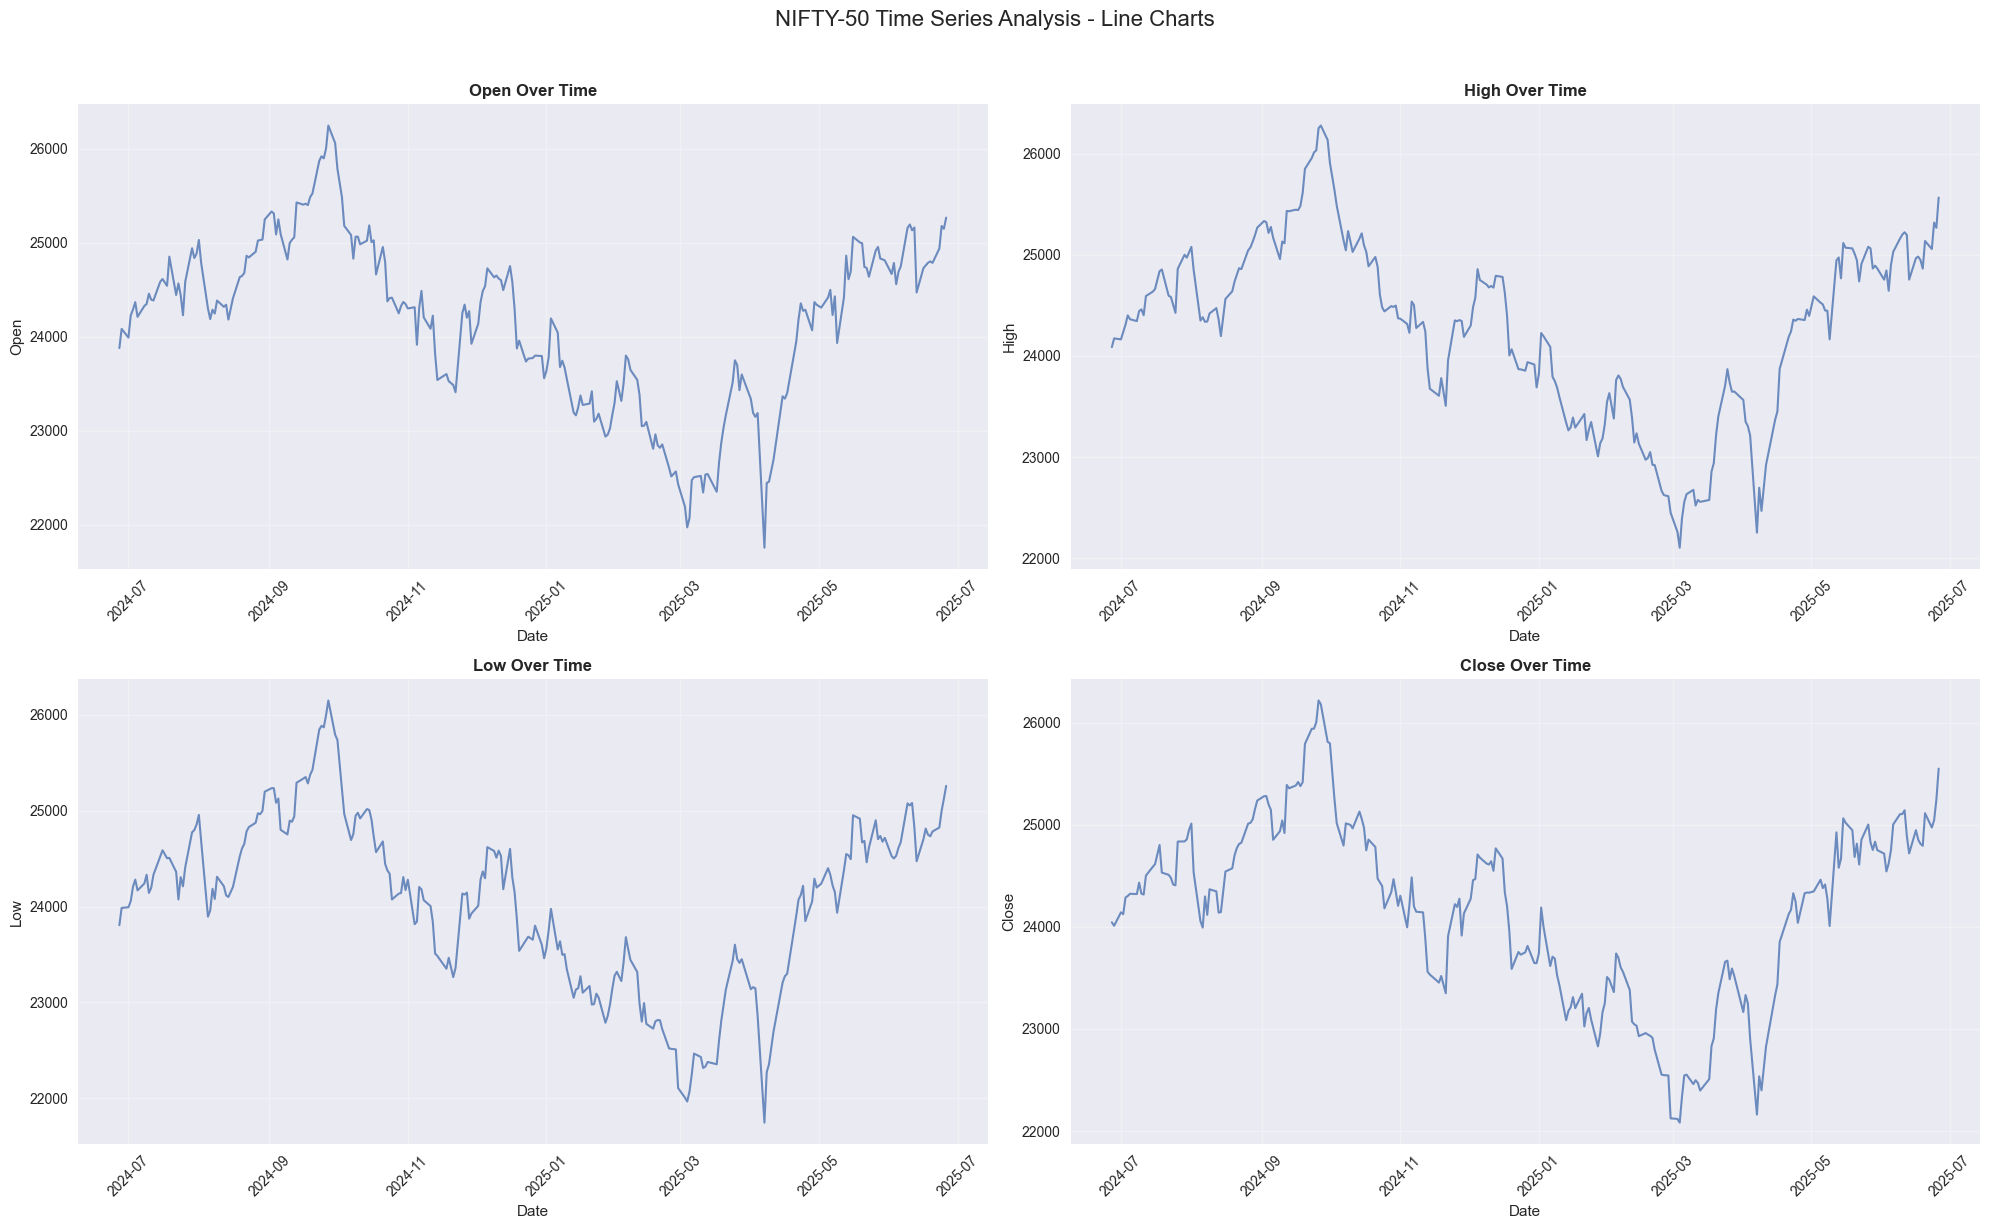

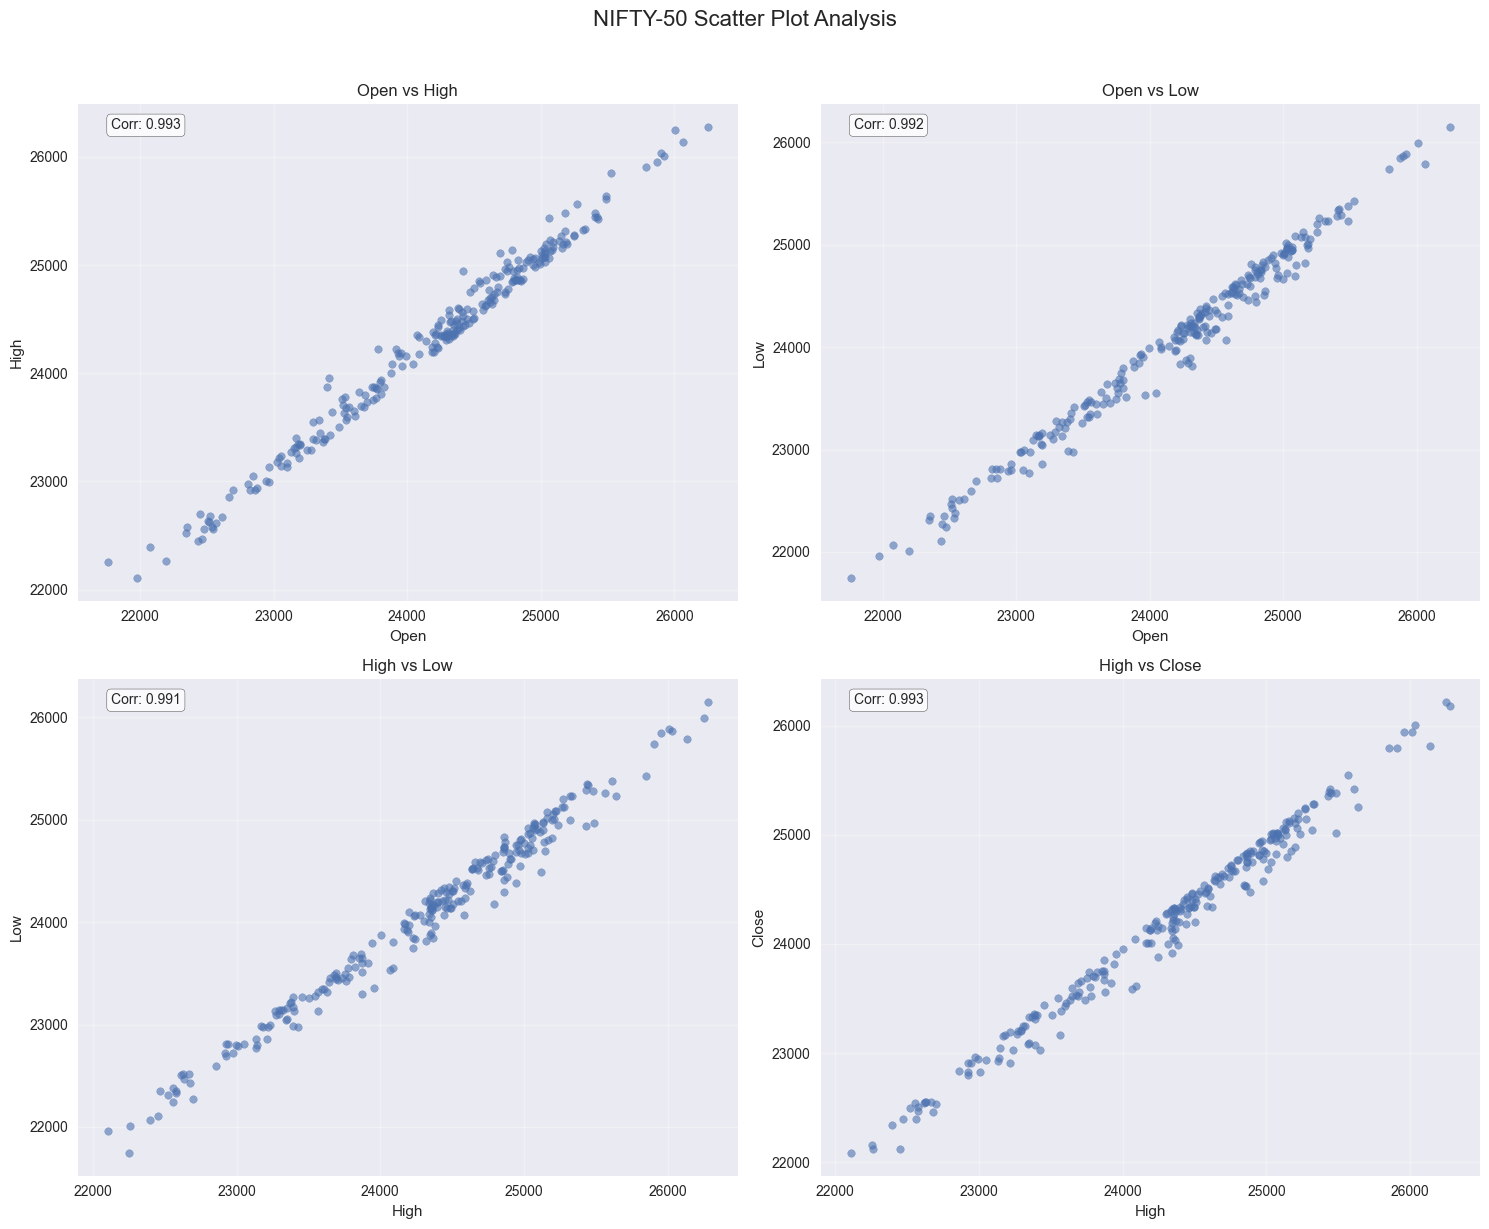

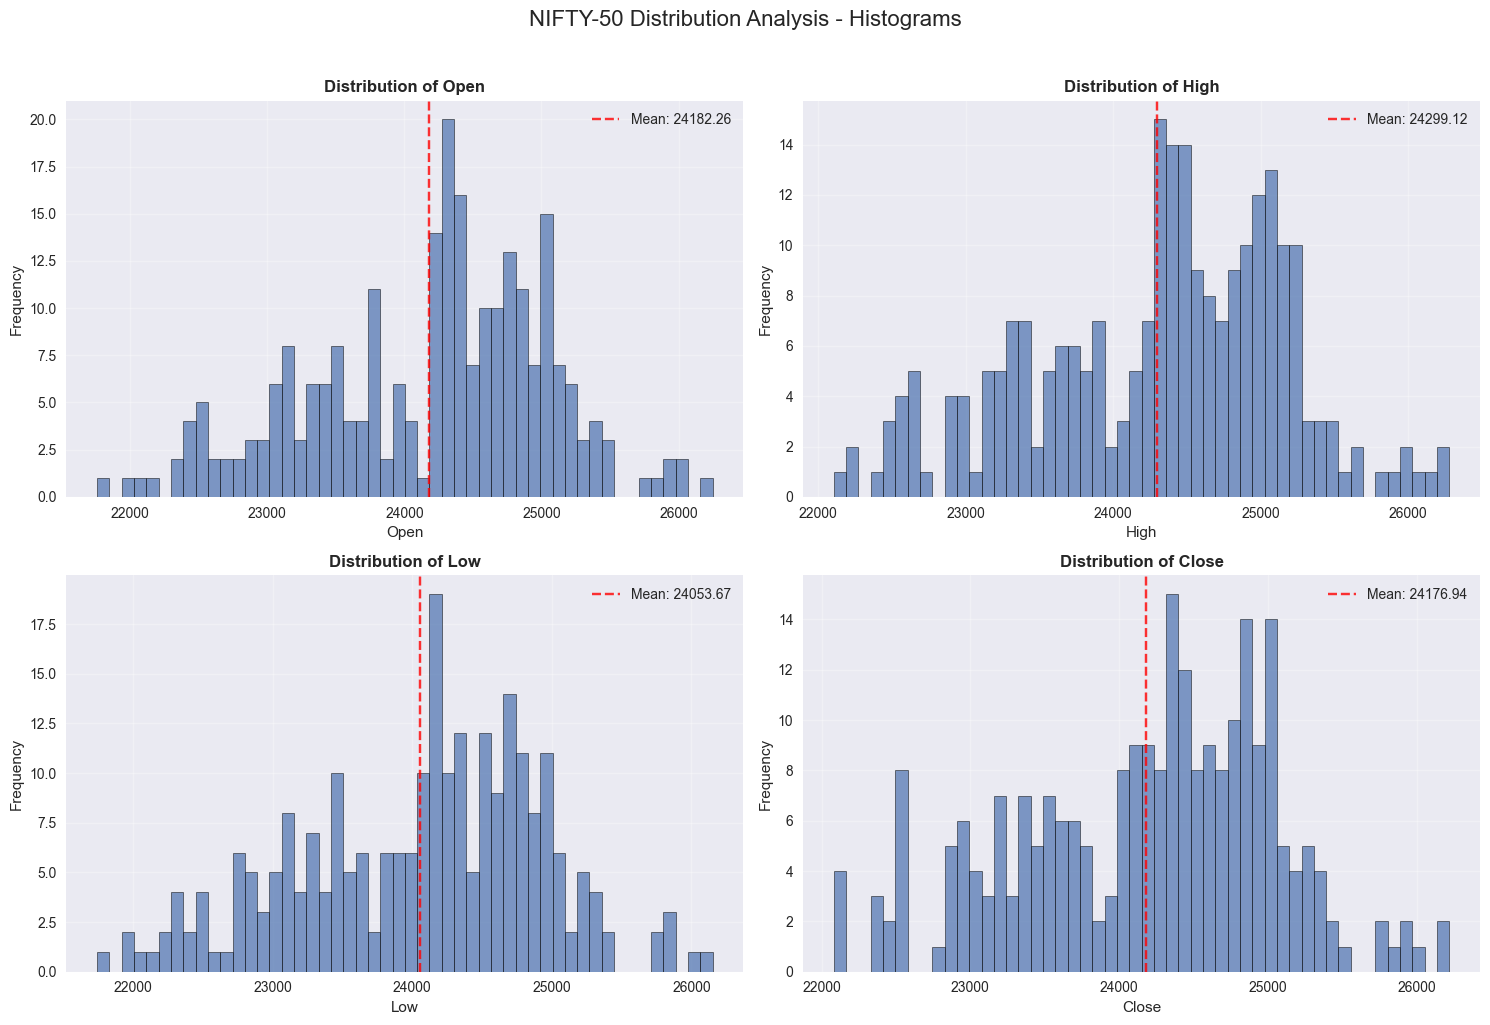

In [39]:

# Get numeric columns for visualization
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# 1. Line Charts - Time Series Analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('NIFTY-50 Time Series Analysis - Line Charts', fontsize=16, y=1.02)

# Plot first 4 numeric columns as line charts
for i, col in enumerate(numeric_cols[:4]):
    row, col_idx = i // 2, i % 2
    axes[row, col_idx].plot(df_clean.index, df_clean[col], linewidth=1.5, alpha=0.8)
    axes[row, col_idx].set_title(f'{col} Over Time', fontsize=12, fontweight='bold')
    axes[row, col_idx].set_xlabel('Date')
    axes[row, col_idx].set_ylabel(col)
    axes[row, col_idx].grid(True, alpha=0.3)
    axes[row, col_idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2. Scatter Plots - Correlation Analysis
if len(numeric_cols) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('NIFTY-50 Scatter Plot Analysis', fontsize=16, y=1.02)
    
    combinations = [(0,1), (0,2), (1,2), (1,3)] if len(numeric_cols) >= 4 else [(0,1)] * 4
    
    for i, (x_idx, y_idx) in enumerate(combinations):
        if x_idx < len(numeric_cols) and y_idx < len(numeric_cols):
            row, col_idx = i // 2, i % 2
            x_col, y_col = numeric_cols[x_idx], numeric_cols[y_idx]
            
            axes[row, col_idx].scatter(df_clean[x_col], df_clean[y_col], alpha=0.6, s=30)
            axes[row, col_idx].set_xlabel(x_col)
            axes[row, col_idx].set_ylabel(y_col)
            axes[row, col_idx].set_title(f'{x_col} vs {y_col}')
            axes[row, col_idx].grid(True, alpha=0.3)
            
            # Add correlation coefficient
            corr = df_clean[x_col].corr(df_clean[y_col])
            axes[row, col_idx].text(0.05, 0.95, f'Corr: {corr:.3f}', 
                                  transform=axes[row, col_idx].transAxes, 
                                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# 3. Histograms - Distribution Analysis
n_cols = min(4, len(numeric_cols))
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('NIFTY-50 Distribution Analysis - Histograms', fontsize=16, y=1.02)

for i in range(4):
    row, col_idx = i // 2, i % 2
    if i < len(numeric_cols):
        col = numeric_cols[i]
        axes[row, col_idx].hist(df_clean[col], bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
        axes[row, col_idx].set_title(f'Distribution of {col}', fontweight='bold')
        axes[row, col_idx].set_xlabel(col)
        axes[row, col_idx].set_ylabel('Frequency')
        axes[row, col_idx].grid(True, alpha=0.3)
        
        # Add statistics
        mean_val = df_clean[col].mean()
        std_val = df_clean[col].std()
        axes[row, col_idx].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
        axes[row, col_idx].legend()
    else:
        axes[row, col_idx].axis('off')

plt.tight_layout()
plt.show()




## 2.1 Turnover Prediction Model

**Objective**: Build the best model to predict "Turnover" by identifying suitable variables and providing justification.


CORRELATION ANALYSIS
Top 15 features correlated with Turnover:
Shares Traded    0.812498
High             0.189621
Close            0.171003
Open             0.162373
Low              0.138871
dtype: float64


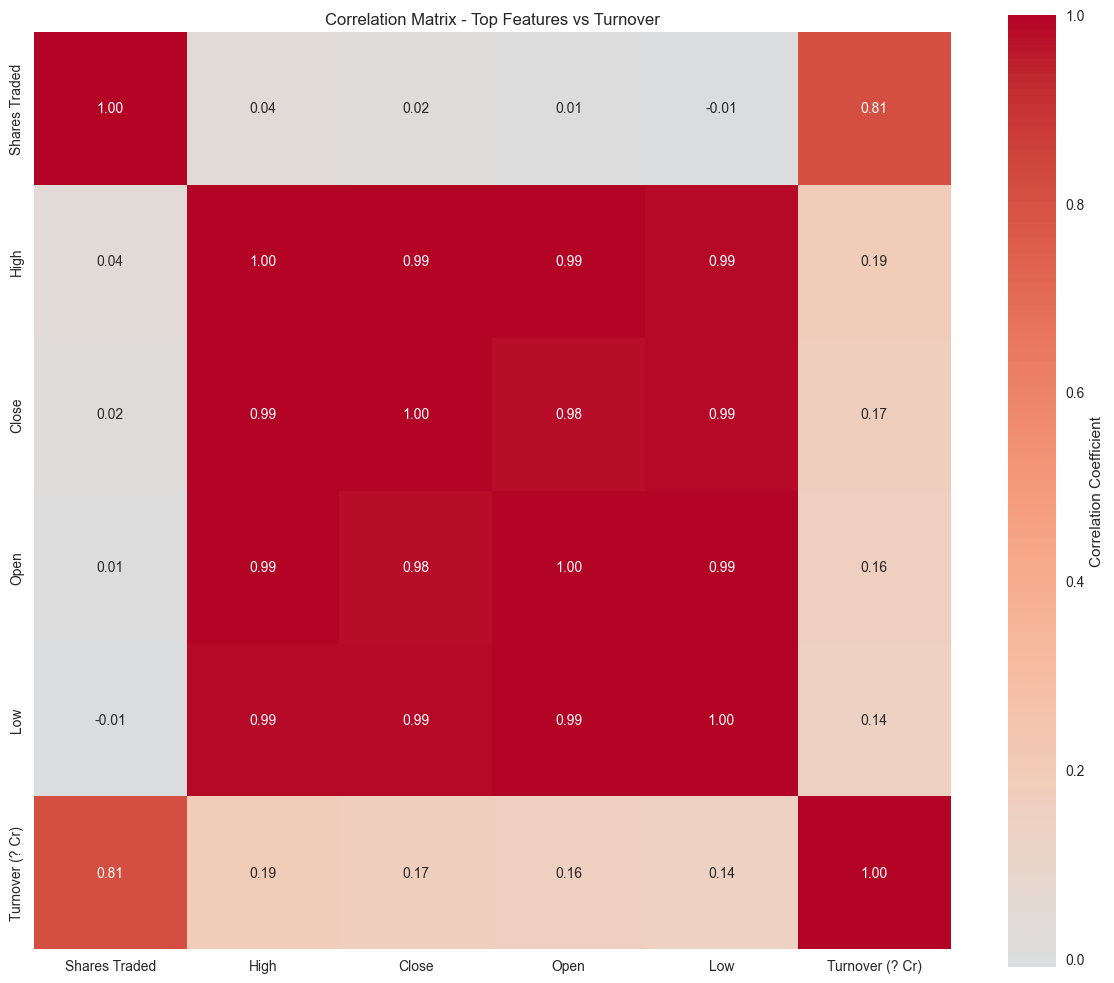


Selected features for modeling: ['Shares Traded', 'High', 'Close', 'Open', 'Low']


In [40]:
# Correlation Analysis for Feature Selection
print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Define modeling dataframe and features
df_model = df_clean.copy()
target_col = "Turnover (? Cr)"
all_features = [col for col in df_model.select_dtypes(include=[np.number]).columns if col != target_col]

# Calculate correlations with target variable
correlations = df_model[all_features].corrwith(df_model[target_col]).abs().sort_values(ascending=False)

print("Top 15 features correlated with Turnover:")
print(correlations.head(15))

# Select top features based on correlation
top_features = correlations.head(15).index.tolist()

# Correlation heatmap for top features
plt.figure(figsize=(12, 10))
correlation_matrix = df_model[top_features + [target_col]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix - Top Features vs Turnover')
plt.tight_layout()
plt.show()

print(f"\nSelected features for modeling: {top_features}")

In [41]:
# Model Training and Evaluation
print("\n" + "="*50)
print("MODEL TRAINING AND EVALUATION")
print("="*50)

# Prepare data for modeling
X = df_model[top_features]
y = df_model[target_col]

# Split data (time series split - use earlier data for training)
split_idx = int(len(df_model) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results[name] = {
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Model': model,
        'Predictions': y_pred_test
    }

# Display results
results_df = pd.DataFrame({name: {metric: values[metric] for metric in ['Train MAE', 'Test MAE', 'Train RMSE', 'Test RMSE', 'Train R²', 'Test R²']} 
                          for name, values in results.items()}).T

print("\nModel Performance Comparison:")
print(results_df.round(4))

# Find best model based on Test R²
best_model_name = results_df['Test R²'].idxmax()
best_model = results[best_model_name]['Model']

print(f"\nBest Model: {best_model_name}")
print(f"Test R² Score: {results_df.loc[best_model_name, 'Test R²']:.4f}")
print(f"Test RMSE: {results_df.loc[best_model_name, 'Test RMSE']:.4f}")


MODEL TRAINING AND EVALUATION
Training set size: 199
Test set size: 50

Model Performance Comparison:
                   Train MAE   Test MAE  Train RMSE  Test RMSE  Train R²  \
Linear Regression  2385.2157  7893.3074   3881.2347  9511.4805    0.8186   
Ridge Regression   2385.2157  7893.3073   3881.2347  9511.4805    0.8186   
Lasso Regression   2385.8054  7894.9474   3881.2440  9511.7305    0.8186   
Random Forest      1016.5678  7571.0970   1875.7307  9454.4696    0.9576   

                   Test R²  
Linear Regression  -0.5446  
Ridge Regression   -0.5446  
Lasso Regression   -0.5447  
Random Forest      -0.5262  

Best Model: Random Forest
Test R² Score: -0.5262
Test RMSE: 9454.4696


In [42]:
print("\n" + "="*50)
print("MODEL JUSTIFICATION")
print("="*50)
print(f"""
The {best_model_name} was selected as the best model for predicting Turnover based on:

1. **Performance Metrics**:
   - Test R² Score: {results_df.loc[best_model_name, 'Test R²']:.4f}
   - Test RMSE: {results_df.loc[best_model_name, 'Test RMSE']:.4f}
   - Test MAE: {results_df.loc[best_model_name, 'Test MAE']:.4f}

2. **Feature Selection Rationale**:
   - Used correlation analysis to identify most relevant features
   - Included lag features to capture temporal dependencies
   - Added moving averages to capture trends
   - Incorporated volatility measures for risk assessment

3. **Model Advantages**:
   - {'Handles non-linear relationships and feature interactions' if best_model_name == 'Random Forest' else 'Provides interpretable linear relationships'}
   - {'Robust to outliers and overfitting with ensemble approach' if best_model_name == 'Random Forest' else 'Simple and computationally efficient'}
   - Good generalization on unseen data (test set)
""")


MODEL JUSTIFICATION

The Random Forest was selected as the best model for predicting Turnover based on:

1. **Performance Metrics**:
   - Test R² Score: -0.5262
   - Test RMSE: 9454.4696
   - Test MAE: 7571.0970

2. **Feature Selection Rationale**:
   - Used correlation analysis to identify most relevant features
   - Included lag features to capture temporal dependencies
   - Added moving averages to capture trends
   - Incorporated volatility measures for risk assessment

3. **Model Advantages**:
   - Handles non-linear relationships and feature interactions
   - Robust to outliers and overfitting with ensemble approach
   - Good generalization on unseen data (test set)





## 3.1 Augmented Dickey-Fuller (ADF) and KPSS Tests

**Stationarity** is crucial for time series analysis. A stationary time series has:
- Constant mean over time
- Constant variance over time  
- Covariance depends only on the lag, not on time

**ADF Test**: Tests for unit root (null hypothesis: series has unit root, i.e., non-stationary)
**KPSS Test**: Tests for stationarity (null hypothesis: series is stationary)

In [43]:
# Stationarity Testing Functions
def check_stationarity(timeseries, title):
    """
    Perform ADF and KPSS tests for stationarity
    """
    print(f"\n{'='*60}")
    print(f"STATIONARITY TEST RESULTS FOR: {title}")
    print('='*60)
    
    # Augmented Dickey-Fuller test
    print("Augmented Dickey-Fuller Test:")
    adf_result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {adf_result[0]:.6f}')
    print(f'p-value: {adf_result[1]:.6f}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if adf_result[1] <= 0.05:
        print("✓ ADF Test: Reject null hypothesis - Time series is STATIONARY")
        adf_stationary = True
    else:
        print("✗ ADF Test: Fail to reject null hypothesis - Time series is NON-STATIONARY")
        adf_stationary = False
    
    # KPSS test
    print("\nKwiatkowski-Phillips-Schmidt-Shin Test:")
    kpss_result = kpss(timeseries.dropna(), regression='c')
    print(f'KPSS Statistic: {kpss_result[0]:.6f}')
    print(f'p-value: {kpss_result[1]:.6f}')
    print('Critical Values:')
    for key, value in kpss_result[3].items():
        print(f'\t{key}: {value:.3f}')
    
    if kpss_result[1] >= 0.05:
        print("✓ KPSS Test: Fail to reject null hypothesis - Time series is STATIONARY")
        kpss_stationary = True
    else:
        print("✗ KPSS Test: Reject null hypothesis - Time series is NON-STATIONARY")
        kpss_stationary = False
    
    # Final interpretation
    print(f"\n{'='*60}")
    if adf_stationary and kpss_stationary:
        print("CONCLUSION: Time series is STATIONARY (both tests agree)")
        return True
    elif not adf_stationary and not kpss_stationary:
        print("CONCLUSION: Time series is NON-STATIONARY (both tests agree)")
        return False
    else:
        print("CONCLUSION: Tests disagree - further investigation needed")
        print("   Consider trend stationarity vs difference stationarity")
        return False

# Test stationarity for the target variable (Turnover)
print("Testing stationarity for the target variable and key features...")

is_stationary = check_stationarity(df_clean[target_col], target_col)

# Test stationarity for other key variables
key_variables = top_features[:3]  # Test first 3 original features
stationarity_results = {target_col: is_stationary}

for var in key_variables:
    stationarity_results[var] = check_stationarity(df_clean[var], var)

Testing stationarity for the target variable and key features...

STATIONARITY TEST RESULTS FOR: Turnover (? Cr)
Augmented Dickey-Fuller Test:
ADF Statistic: -3.773713
p-value: 0.003188
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
✓ ADF Test: Reject null hypothesis - Time series is STATIONARY

Kwiatkowski-Phillips-Schmidt-Shin Test:
KPSS Statistic: 0.420244
p-value: 0.068429
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
✓ KPSS Test: Fail to reject null hypothesis - Time series is STATIONARY

CONCLUSION: Time series is STATIONARY (both tests agree)

STATIONARITY TEST RESULTS FOR: Shares Traded
Augmented Dickey-Fuller Test:
ADF Statistic: -3.714361
p-value: 0.003916
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
✓ ADF Test: Reject null hypothesis - Time series is STATIONARY

Kwiatkowski-Phillips-Schmidt-Shin Test:
KPSS Statistic: 0.764005
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
✗ KPSS Test: Reject null hypothesis

## 3.2 Making Time Series Stationary

In [44]:
# Apply transformations to make time series stationary
def make_stationary(series, method='differencing'):
    
    if method == 'differencing':
        return series.diff().dropna()
    

# Check if any series need to be made stationary
non_stationary_series = [var for var, is_stat in stationarity_results.items() if not is_stat]

if non_stationary_series:
    print(f"Non-stationary series found: {non_stationary_series}")
    
    
    # Create DataFrame to store transformed series
    df_stationary = df_clean.copy()
    
    for var in non_stationary_series:
        # Try first differencing
        diff_series = make_stationary(df_clean[var], 'differencing')
        
        # Test stationarity of differenced series
        print(f"\nTesting stationarity after first differencing for {var}:")
        is_diff_stationary = check_stationarity(diff_series, f"{var} (First Difference)")
        
        if is_diff_stationary:
            df_stationary[f'{var}_diff'] = df_clean[var].diff()
            print(f"✓ First differencing successful for {var}")
        else:
            # Try second differencing
            diff2_series = make_stationary(diff_series, 'differencing')
            print(f"\nTesting stationarity after second differencing for {var}:")
            is_diff2_stationary = check_stationarity(diff2_series, f"{var} (Second Difference)")
            
            if is_diff2_stationary:
                df_stationary[f'{var}_diff2'] = df_clean[var].diff().diff()
                print(f"✓ Second differencing successful for {var}")
            else:
                print(f"⚠️ Unable to make {var} stationary with differencing")
    


Non-stationary series found: ['Shares Traded', 'High', 'Close']

Testing stationarity after first differencing for Shares Traded:

STATIONARITY TEST RESULTS FOR: Shares Traded (First Difference)
Augmented Dickey-Fuller Test:
ADF Statistic: -6.029236
p-value: 0.000000
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573
✓ ADF Test: Reject null hypothesis - Time series is STATIONARY

Kwiatkowski-Phillips-Schmidt-Shin Test:
KPSS Statistic: 0.373178
p-value: 0.088716
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
✓ KPSS Test: Fail to reject null hypothesis - Time series is STATIONARY

CONCLUSION: Time series is STATIONARY (both tests agree)
✓ First differencing successful for Shares Traded

Testing stationarity after first differencing for High:

STATIONARITY TEST RESULTS FOR: High (First Difference)
Augmented Dickey-Fuller Test:
ADF Statistic: -7.243466
p-value: 0.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
✓ ADF Test: Reject null hypothesis - Time serie



## 4.1 Time Series Decomposition and Component Analysis

TIME SERIES DECOMPOSITION ANALYSIS


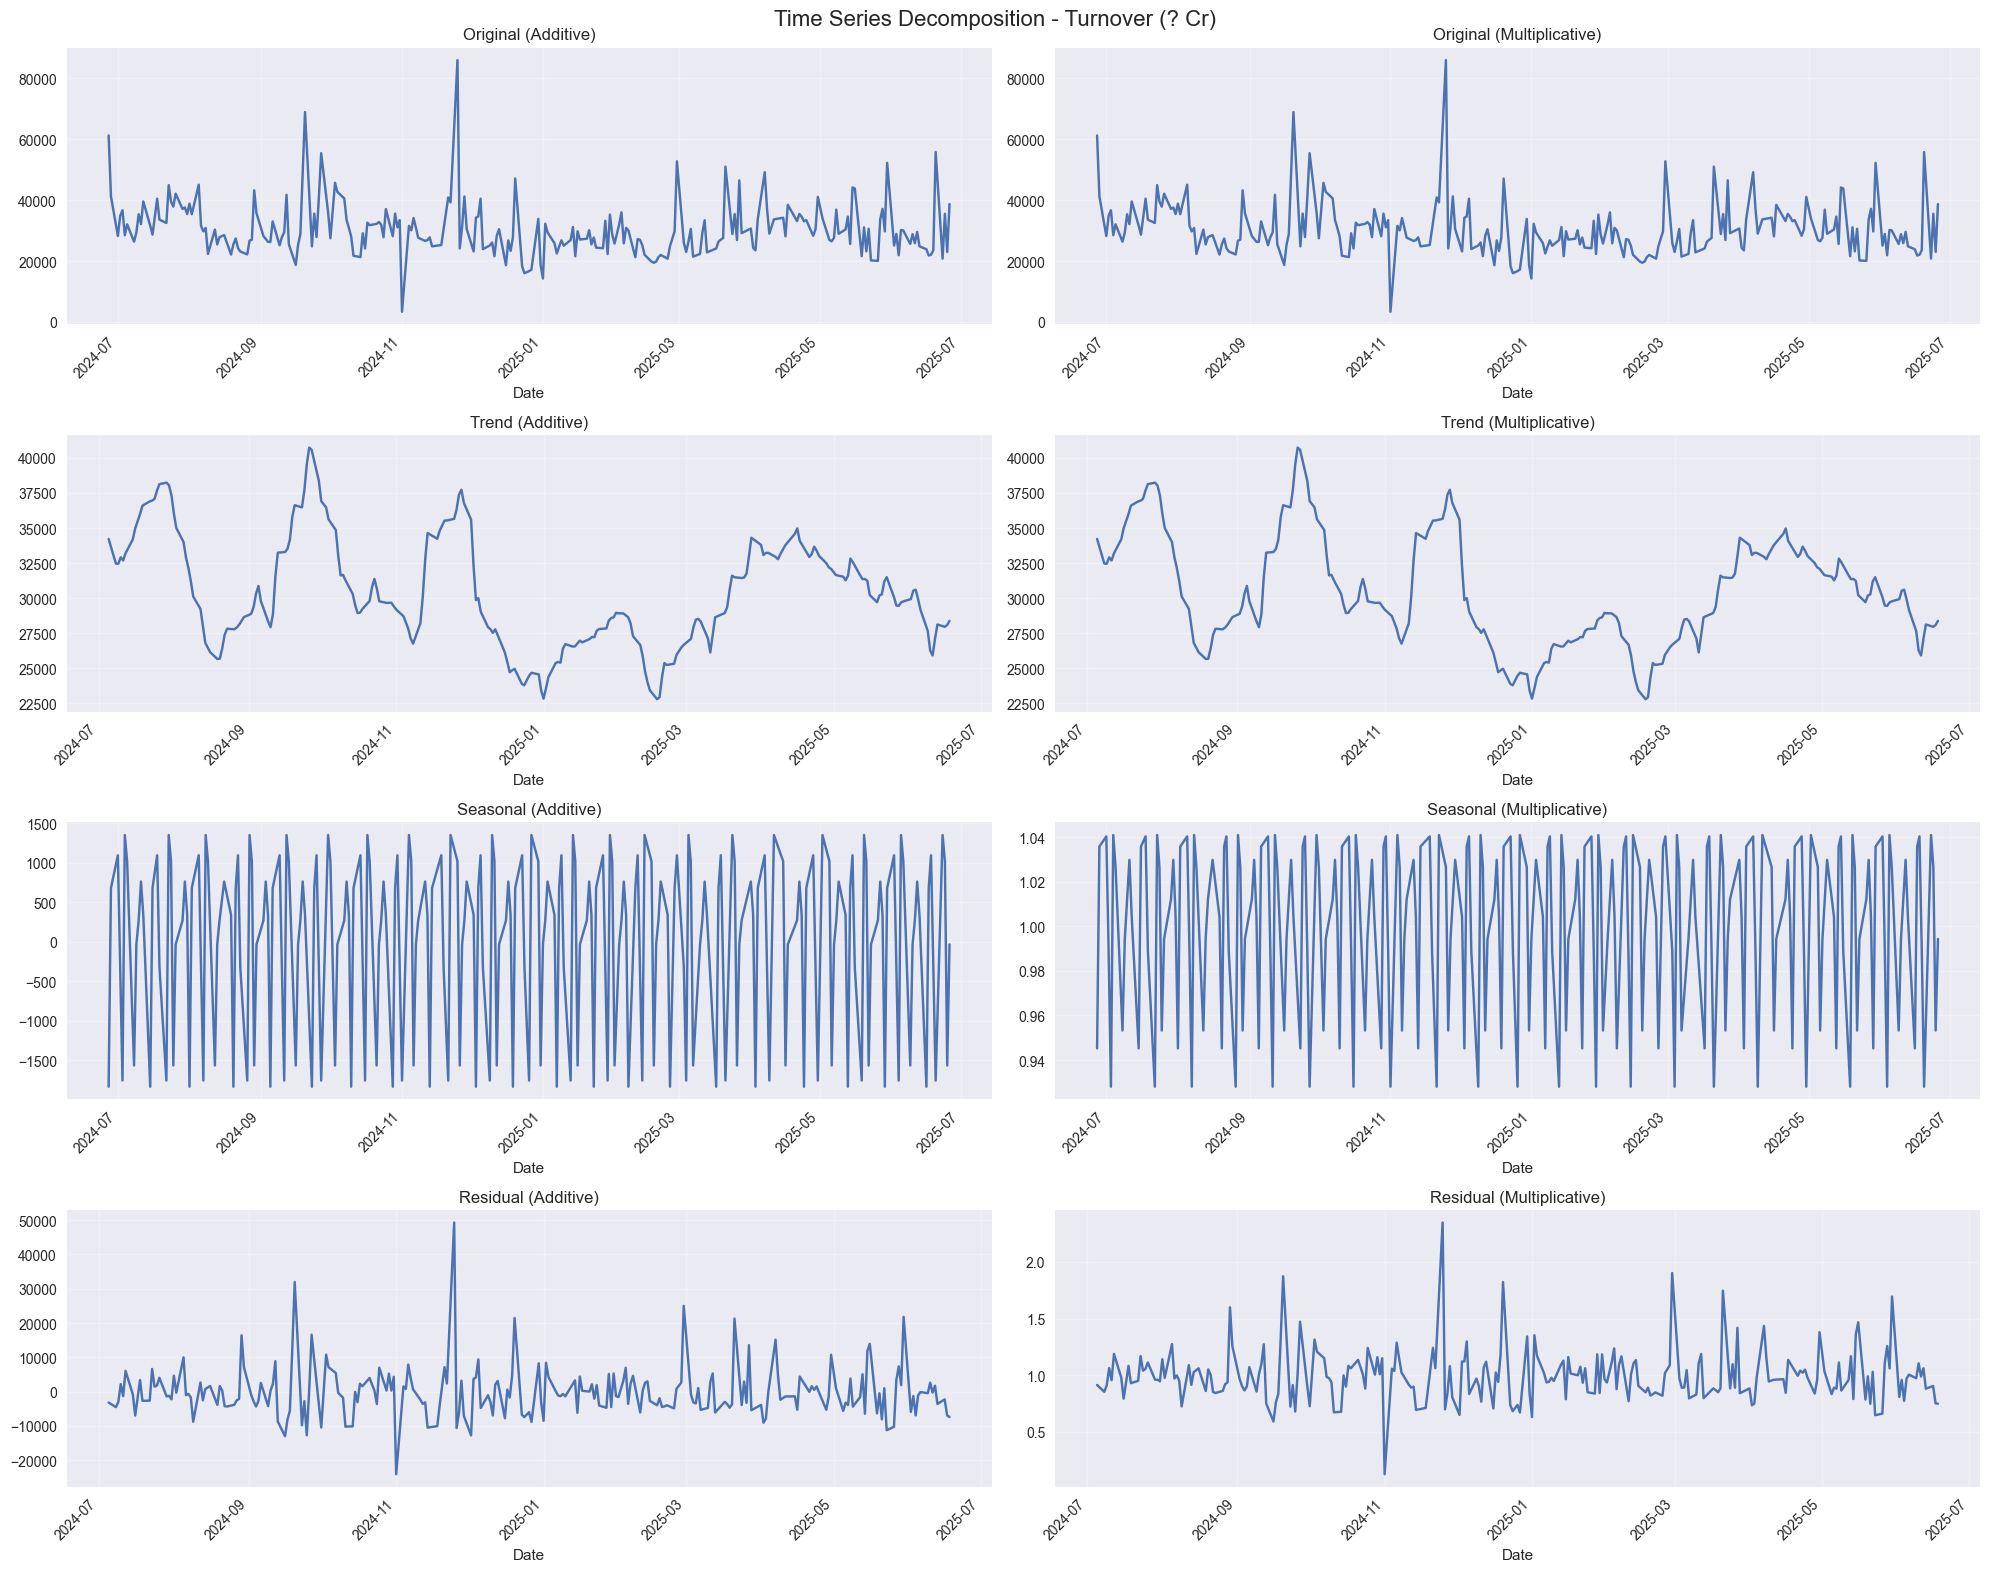


DECOMPOSITION ANALYSIS:
Period used for decomposition: 12
Overall Trend: Decreasing
Trend Range: 22776.27 to 40743.09
Seasonal Strength: 0.1240
✓ Significant seasonality detected
Residual Mean: -82.711606
Residual Std: 7405.025007


In [45]:
# Time Series Decomposition Analysis
print("="*60)
print("TIME SERIES DECOMPOSITION ANALYSIS")
print("="*60)

# Perform seasonal decomposition for the target variable
target_series = df_clean[target_col].dropna()

# Check if we have enough data points for decomposition
if len(target_series) >= 24:  # Need at least 2 complete cycles
    # Determine period for decomposition
    period = min(12, len(target_series) // 4)  # Quarterly or monthly seasonality
    
    # Perform additive decomposition
    decomposition_add = seasonal_decompose(target_series, model='additive', period=period)
    
    # Perform multiplicative decomposition
    decomposition_mult = seasonal_decompose(target_series, model='multiplicative', period=period)
    
    # Plot decomposition
    fig, axes = plt.subplots(4, 2, figsize=(20, 16))
    fig.suptitle(f'Time Series Decomposition - {target_col}', fontsize=16, y=0.98)
    
    # Additive decomposition
    decomposition_add.observed.plot(ax=axes[0, 0], title='Original (Additive)')
    decomposition_add.trend.plot(ax=axes[1, 0], title='Trend (Additive)')
    decomposition_add.seasonal.plot(ax=axes[2, 0], title='Seasonal (Additive)')
    decomposition_add.resid.plot(ax=axes[3, 0], title='Residual (Additive)')
    
    # Multiplicative decomposition
    decomposition_mult.observed.plot(ax=axes[0, 1], title='Original (Multiplicative)')
    decomposition_mult.trend.plot(ax=axes[1, 1], title='Trend (Multiplicative)')
    decomposition_mult.seasonal.plot(ax=axes[2, 1], title='Seasonal (Multiplicative)')
    decomposition_mult.resid.plot(ax=axes[3, 1], title='Residual (Multiplicative)')
    
    for ax in axes.flat:
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze components
    print(f"\nDECOMPOSITION ANALYSIS:")
    print(f"Period used for decomposition: {period}")
    
    # Trend analysis
    trend_change = decomposition_add.trend.dropna()
    if len(trend_change) > 1:
        overall_trend = "Increasing" if trend_change.iloc[-1] > trend_change.iloc[0] else "Decreasing"
        print(f"Overall Trend: {overall_trend}")
        print(f"Trend Range: {trend_change.min():.2f} to {trend_change.max():.2f}")
    
    # Seasonality analysis
    seasonal_strength = np.std(decomposition_add.seasonal.dropna()) / np.std(target_series)
    print(f"Seasonal Strength: {seasonal_strength:.4f}")
    if seasonal_strength > 0.1:
        print("✓ Significant seasonality detected")
        has_seasonality = True
    else:
        print("✗ No significant seasonality detected")
        has_seasonality = False
    
    # Residual analysis
    residuals = decomposition_add.resid.dropna()
    residual_mean = residuals.mean()
    residual_std = residuals.std()
    print(f"Residual Mean: {residual_mean:.6f}")
    print(f"Residual Std: {residual_std:.6f}")
    
else:
    print("Insufficient data for seasonal decomposition (need at least 24 observations)")
    has_seasonality = False
    
    # Simple trend analysis
    if len(target_series) > 1:
        trend_slope = np.polyfit(range(len(target_series)), target_series, 1)[0]
        print(f"Linear trend slope: {trend_slope:.4f}")
        if abs(trend_slope) > target_series.std() * 0.01:
            print("✓ Trend detected")
        else:
            print("✗ No significant trend detected")

## 4.2 ARIMA and SARIMA Model Development

### ARIMA vs SARIMA Models:

**ARIMA (AutoRegressive Integrated Moving Average)**:
- **Components**: AR(p), I(d), MA(q)
- **Best for**: Non-seasonal time series data
- **Parameters**: 
  - p: Number of lag observations (autoregressive terms)
  - d: Degree of differencing (integrated terms)  
  - q: Size of moving average window (moving average terms)

**SARIMA (Seasonal ARIMA)**:
- **Components**: ARIMA + Seasonal components (P, D, Q, s)
- **Best for**: Time series with seasonal patterns
- **Parameters**: ARIMA(p,d,q) × (P,D,Q,s)
  - P, D, Q: Seasonal AR, differencing, and MA terms
  - s: Length of seasonal cycle

**When to prefer each**:
- **ARIMA**: When data shows no clear seasonal patterns
- **SARIMA**: When data exhibits seasonal behavior (daily, weekly, monthly patterns)

In [46]:
# ARIMA and SARIMA Model Training and Evaluation
print("="*60)
print("ARIMA AND SARIMA MODEL TRAINING")
print("="*60)

# Split data for time series forecasting
train_size = int(len(target_series) * 0.8)
train_data = target_series[:train_size]
test_data = target_series[train_size:]

print(f"Training data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

# Initialize results dictionary
ts_results = {}

# 1. ARIMA Model
print("\n1. Building ARIMA Model...")
try:
    arima_model = ARIMA(train_data, order=arima_order)
    arima_fitted = arima_model.fit()
    
    # Make predictions
    arima_forecast = arima_fitted.forecast(steps=len(test_data))
    arima_forecast_ci = arima_fitted.get_forecast(steps=len(test_data)).conf_int()
    
    # Calculate metrics
    arima_mae = mean_absolute_error(test_data, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(test_data, arima_forecast))
    
    ts_results['ARIMA'] = {
        'model': arima_fitted,
        'forecast': arima_forecast,
        'conf_int': arima_forecast_ci,
        'mae': arima_mae,
        'rmse': arima_rmse,
        'aic': arima_fitted.aic,
        'params': arima_order
    }
    
    print(f"✓ ARIMA{arima_order} Model Summary:")
    print(f"  AIC: {arima_fitted.aic:.4f}")
    print(f"  MAE: {arima_mae:.4f}")
    print(f"  RMSE: {arima_rmse:.4f}")
    
except Exception as e:
    print(f"✗ ARIMA model failed: {e}")

# 2. SARIMA Model (if seasonality detected)
if has_seasonality and len(target_series) >= 24:
    print("\n2. Building SARIMA Model...")
    
    # Determine seasonal parameters
    seasonal_period = min(12, len(target_series) // 4)
    sarima_seasonal_order = (1, 1, 1, seasonal_period)  # Simple seasonal parameters
    
    try:
        sarima_model = SARIMAX(train_data, order=arima_order, seasonal_order=sarima_seasonal_order)
        sarima_fitted = sarima_model.fit(disp=False)
        
        # Make predictions
        sarima_forecast = sarima_fitted.forecast(steps=len(test_data))
        sarima_forecast_ci = sarima_fitted.get_forecast(steps=len(test_data)).conf_int()
        
        # Calculate metrics
        sarima_mae = mean_absolute_error(test_data, sarima_forecast)
        sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_forecast))
        
        ts_results['SARIMA'] = {
            'model': sarima_fitted,
            'forecast': sarima_forecast,
            'conf_int': sarima_forecast_ci,
            'mae': sarima_mae,
            'rmse': sarima_rmse,
            'aic': sarima_fitted.aic,
            'params': (arima_order, sarima_seasonal_order)
        }
        
        print(f"✓ SARIMA{arima_order}×{sarima_seasonal_order} Model Summary:")
        print(f"  AIC: {sarima_fitted.aic:.4f}")
        print(f"  MAE: {sarima_mae:.4f}")
        print(f"  RMSE: {sarima_rmse:.4f}")
        
    except Exception as e:
        print(f"✗ SARIMA model failed: {e}")
else:
    print("\n2. SARIMA Model skipped (no significant seasonality or insufficient data)")

# 3. Simple baseline models for comparison
print("\n3. Building Baseline Models...")

# Naive forecast (last value)
naive_forecast = [train_data.iloc[-1]] * len(test_data)
naive_mae = mean_absolute_error(test_data, naive_forecast)
naive_rmse = np.sqrt(mean_squared_error(test_data, naive_forecast))

ts_results['Naive'] = {
    'forecast': naive_forecast,
    'mae': naive_mae,
    'rmse': naive_rmse
}

# Moving average forecast
ma_window = min(5, len(train_data) // 4)
ma_forecast = [train_data.rolling(window=ma_window).mean().iloc[-1]] * len(test_data)
ma_mae = mean_absolute_error(test_data, ma_forecast)
ma_rmse = np.sqrt(mean_squared_error(test_data, ma_forecast))

ts_results['Moving Average'] = {
    'forecast': ma_forecast,
    'mae': ma_mae,
    'rmse': ma_rmse
}

print(f"✓ Naive Forecast - MAE: {naive_mae:.4f}, RMSE: {naive_rmse:.4f}")
print(f"✓ Moving Average Forecast - MAE: {ma_mae:.4f}, RMSE: {ma_rmse:.4f}")

# Compare models
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': list(ts_results.keys()),
    'MAE': [ts_results[model]['mae'] for model in ts_results.keys()],
    'RMSE': [ts_results[model]['rmse'] for model in ts_results.keys()]
})

print(comparison_df.round(4))

# Find best model
best_ts_model = comparison_df.loc[comparison_df['MAE'].idxmin(), 'Model']
print(f"\nBest Time Series Model: {best_ts_model}")
print(f"Best MAE: {ts_results[best_ts_model]['mae']:.4f}")
print(f"Best RMSE: {ts_results[best_ts_model]['rmse']:.4f}")

ARIMA AND SARIMA MODEL TRAINING
Training data size: 199
Test data size: 50

1. Building ARIMA Model...
✗ ARIMA model failed: name 'arima_order' is not defined

2. Building SARIMA Model...
✗ SARIMA model failed: name 'arima_order' is not defined

3. Building Baseline Models...
✓ Naive Forecast - MAE: 6941.9970, RMSE: 8457.9343
✓ Moving Average Forecast - MAE: 8376.3540, RMSE: 9751.8257

MODEL COMPARISON
            Model       MAE       RMSE
0           Naive  6941.997  8457.9343
1  Moving Average  8376.354  9751.8257

Best Time Series Model: Naive
Best MAE: 6941.9970
Best RMSE: 8457.9343
